In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip3 install tensorflow_text
!pip install sentencepiece

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import concat
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Input, Concatenate, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Lambda, GlobalAveragePooling1D,AveragePooling1D, GlobalMaxPool1D
import time
import csv
import tensorflow_text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import plotly
import plotly.graph_objs as go
from sklearn.manifold import TSNE

In [25]:
train_data_path = '/content/drive/My Drive/Univer/Diploma/data_tok/dfs.csv'
train_data = pd.read_csv(train_data_path, sep = ',')

train_data_nonisa_path = '/content/drive/My Drive/Univer/Diploma/data_tok/dfs_nonisa.csv'
train_data_nonisa = pd.read_csv(train_data_nonisa_path, sep = ',')

In [26]:
train_data.head(3)

,f,s
0,расширенной моделью,тематическая модель
1,кубов olap,организации хранения данных
2,си,языках программирования


Tokenization and vectorization

In [27]:
first_word = []
second_word = []

for i, row in enumerate(train_data['f']):
  first_word.append(row)

for i, row in enumerate(train_data['s']):
  second_word.append(row)

In [28]:
import sentencepiece as spm

def spm_apply(input_text: list, model_name: str, alpha=0.1, enable_sampling=True, nbest_size=2):
    '''If you use unigram model, you should define the variable model_name = 'm_unigram.model' '''

    sp = spm.SentencePieceProcessor()

    global time

    start_time = time.time()
    sp.load(model_name)
    subword_tokens_list = []
    subword_vectors_list = []


    for text in input_text:
        subword_tokens_list.append(sp.encode_as_pieces(text))
        subword_vectors_list.append(sp.encode(str(text), alpha=0.1))

    end_time = time.time()
    work_time = end_time - start_time
    print(f'Time: {work_time}')
    assert len(subword_tokens_list) > 0
    print(f'List with subword was written successfuly!')
    print(f'Len of input_text: {len(input_text)}')
    print(f'Len of subword_tokens_list: {len(subword_tokens_list)}' + '\n')
    return subword_tokens_list, subword_vectors_list

In [29]:
model_path = '/content/drive/My Drive/Univer/Diploma/data_tok/model_bpe_dip.model'
first_tokens, first_vectors = spm_apply(first_word, model_path)
second_tokens, second_vectors = spm_apply(second_word, model_path)

Time: 0.011902093887329102
List with subword was written successfuly!
Len of input_text: 70
Len of subword_tokens_list: 70

Time: 0.010678529739379883
List with subword was written successfuly!
Len of input_text: 70
Len of subword_tokens_list: 70



Padding

In [30]:
MAX_SEQ_LEN_words = 10

In [31]:
w_tokens = first_tokens + second_tokens
w_vectors = first_vectors + second_vectors

In [32]:
first_words_pad = pad_sequences(first_vectors, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')
second_words_pad = pad_sequences(second_vectors, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

w_vectors_pad = pad_sequences(w_vectors, maxlen=MAX_SEQ_LEN_words, padding='post', truncating='post')

Getting embeddings and visualization

In [33]:
embed_words = Embedding(10000,512)
avg = GlobalAveragePooling1D()

embed_fw = embed_words(first_words_pad)
embed_sw = embed_words(second_words_pad)
embed_w = embed_words(w_vectors_pad)

In [34]:
new = []
for i in w_tokens:
  a = ",".join(i).replace(',', '').replace('▁',' ')
  new.append([a])

In [35]:
avg_w = avg(embed_w)
avg_w.shape

TensorShape([140, 512])

In [36]:
avg_w = np.reshape(avg_w, (140,1,512))

In [37]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32, metric="cosine")
embedding_clusters = np.array(avg_w)
n, m, k = avg_w.shape
embeddings_en_2d_2 = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

No handles with labels found to put in legend.


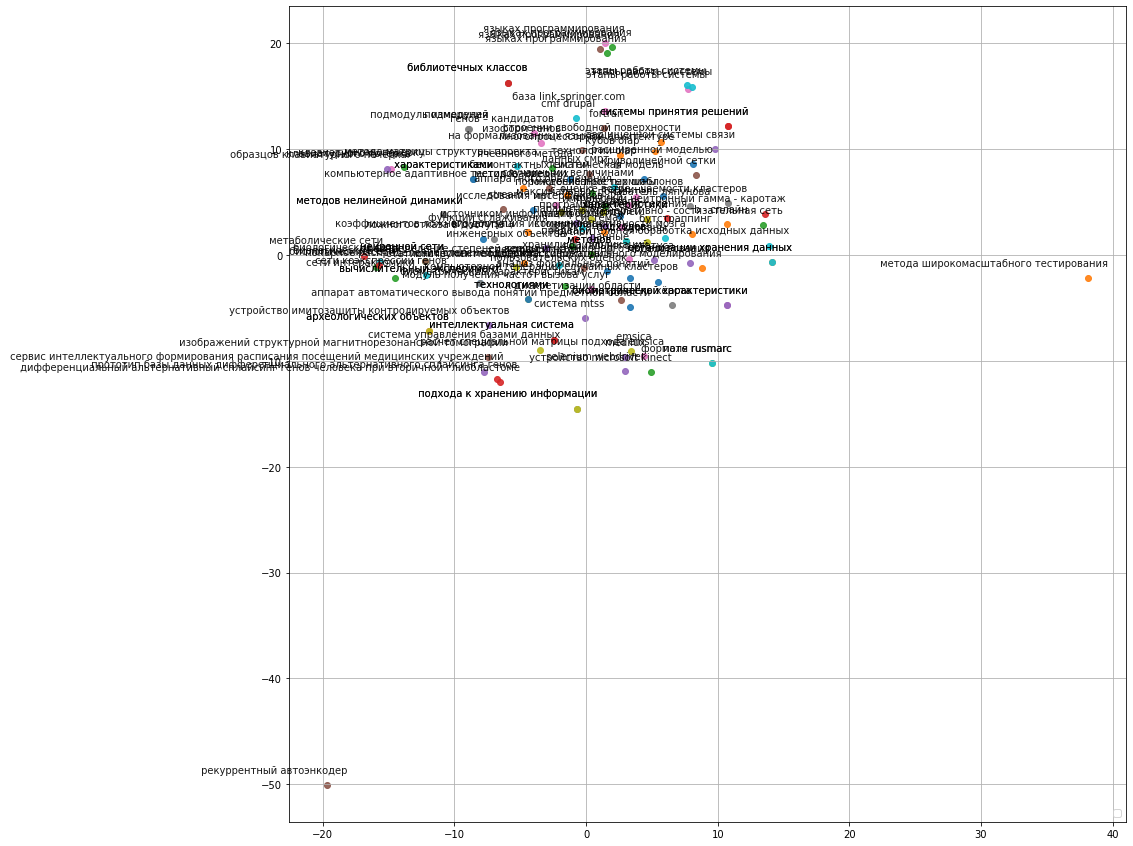

In [38]:
def tsne_plot_similar_words(embedding_clusters, word_clusters, a=0.9):
    plt.figure(figsize=(15, 15))
    #colors = cm.rainbow(np.linspace(0, 1))
    for embeddings, words in zip(embedding_clusters, word_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, alpha=a)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.9, xy=(x[i], y[i]), xytext=(20, 10), 
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("/content/drive/My Drive/Univer/Diploma/data_tok/graphs_words_isa_spm.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_similar_words(embeddings_en_2d_2, new)